In [1]:
import pandas as pd
import sys
import seaborn as sns
sys.path.append('utilities')
import helpers as h
import matplotlib.pyplot as plt
import requests
from rapidfuzz import process, fuzz

# 1: Reading files from disk into memory
start by reading the file locations from file, then load the excel file, list the sheets and load them all into variables. Next load the y_test.csv file.

In [2]:
files = h.get_file_organization(True)

,Key,File Path,Explanation
0,raw_data,c:\Python projects\regression task\evaluatie-2...,Training dataset in Excel format as downloaded...
1,y_testdata,c:\Python projects\regression task\evaluatie-2...,Training testdata as downloaded from mail in C...


In [3]:
excel_file = pd.ExcelFile(files['raw_data'])
X_train, X_test, y_train = [pd.read_excel(files['raw_data'], sheet_name= sheet) for sheet in excel_file.sheet_names]
# X_train, X_text, y_train =
y_test = pd.read_csv(files['y_testdata'])
excel_file.close()
assert(len(X_train) == len(y_train))

# 2: EDA - what data/columns do we have?

In [4]:
X_train.head(5)

,work_year,experience_level,employment_type,job_title,employee_residence,work_setting,company_location,company_size
0,2023,Mid-level,Full-time,Machine Learning Engineer,United States,In-person,United States,M
1,2023,Mid-level,Full-time,Data Scientist,United States,In-person,United States,M
2,2024,Senior,Full-time,Data Scientist,United Kingdom,In-person,United Kingdom,M
3,2024,Senior,Full-time,Data Scientist,United States,Remote,United States,M
4,2024,Senior,Full-time,Data Scientist,United Kingdom,Remote,United Kingdom,M


In [5]:
y_train.head(5)

,salary_in_eur
0,188140.00
1,155480.00
2,36800.00
3,88113.92
4,59800.00


## 2.1 single df: 
We want to have a single df with y_train as the target column for easier plotting in our EDA phase. 

In [6]:
df = X_train.copy()
df['target'] = y_train

In [7]:
df.head(5)

,work_year,experience_level,employment_type,job_title,employee_residence,work_setting,company_location,company_size,target
0,2023,Mid-level,Full-time,Machine Learning Engineer,United States,In-person,United States,M,188140.00
1,2023,Mid-level,Full-time,Data Scientist,United States,In-person,United States,M,155480.00
2,2024,Senior,Full-time,Data Scientist,United Kingdom,In-person,United Kingdom,M,36800.00
3,2024,Senior,Full-time,Data Scientist,United States,Remote,United States,M,88113.92
4,2024,Senior,Full-time,Data Scientist,United Kingdom,Remote,United Kingdom,M,59800.00


## 2.2 Column inspection:
What is the range of values we're working with - at a first glance there seem to be quite some columns that might be suitable for ordinal encoding (e.g. company_size or experience_level). But for it to work properly we need to have clearly distinguished values in these columns. (e.g. S,M,L and not S,M,L, 100-1000, 1000-2500 for company_size)

In [8]:
df.nunique()
# we see that there is potential to use ordinal encoding for experience_level and company_size. We might consider employment_type and work_setting too if we can find a meaningful hierarchy there.

work_year                5
experience_level         4
employment_type          4
job_title              145
employee_residence      84
work_setting             3
company_location        73
company_size             3
target                2115
dtype: int64

In [9]:
for column in df.columns:
    if df[column].nunique() < 6:
        print(column, '\t', df[column].unique())

work_year 	 [2023 2024 2022 2020 2021]
experience_level 	 ['Mid-level' 'Senior' 'Entry-level' 'Executive']
employment_type 	 ['Full-time' 'Freelance' 'Contract' 'Part-time']
work_setting 	 ['In-person' 'Remote' 'Hybrid']
company_size 	 ['M' 'L' 'S']


I'm comfortable calling **experience_level** and **company_size** ordinal values and using ordinal encoding on them. There's a clear hierarchy in the unique values printed for these columns. 
I'm less convinced that **employment_type** and **work_setting** shoudl be treated in a similar way. 
- consider *Contract*: is that a full-time or part-time contract? 
- consider *Part-time*: what's the percentage? 
- consider *Hybrid*: What's the ratio between remote and in-person?

At this point we're curious as to why there's so many **company_location**, **job_title** and **employee_residence** values. 
- to be considered: are there **company_locations** that are hyperspecific (e.g. U.S. vs U.S. - Texas)?
- to be considered: are there **job_titles** that are synonyms (e.g. Lead Dev vs Lead developer) or similar (e.g. Docker vs Kubernetes)?

In [10]:
def get_alphabetically(df, column):
    """Takes a pandas DF (df) and a string (column) which is the name of a column in df
    and returns an alphabetical list of values in that column. """
    l = df[column].unique()
    l.sort()
    return l 

def cleanup_strings(df, column, kvdict): 
    """Takes a pandas DF (df), a string (column) which is the name of a column in df 
    and a python dictionary in key(str)-value(str) formwat where key is the value 
    to be replace and value is the stringvalue it should be replaced with"""
    df = df.copy()
    df[column] = df[column].str.lower() #better for fuzzy matching required in stage 5
    for key, value in kvdict.items():
        df[column] = df[column].str.replace(key, value, regex=True)
    return df

In [11]:
print(get_alphabetically(df, 'company_location'))
#no, there's no hyperspecificity in countries - but if we use one-hot encoding, we should make it easy for ourselves change the name of some countries
#   - remove ü
#   - all to lowercase
#   - remove spaces
#   - get rid of comma's 

['Algeria' 'American Samoa' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Bahamas' 'Belgium' 'Bosnia and Herzegovina' 'Brazil' 'Canada'
 'Central African Republic' 'China' 'Colombia' 'Croatia' 'Czechia'
 'Denmark' 'Ecuador' 'Egypt' 'Estonia' 'Finland' 'France' 'Germany'
 'Ghana' 'Gibraltar' 'Greece' 'Honduras' 'Hungary' 'India' 'Indonesia'
 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kenya' 'Korea, Republic of' 'Latvia' 'Lebanon' 'Lithuania' 'Luxembourg'
 'Malaysia' 'Malta' 'Mauritius' 'Mexico' 'Moldova, Republic of'
 'Netherlands' 'New Zealand' 'Nigeria' 'Oman' 'Pakistan' 'Philippines'
 'Poland' 'Portugal' 'Puerto Rico' 'Qatar' 'Romania' 'Russian Federation'
 'Saudi Arabia' 'Singapore' 'Slovenia' 'South Africa' 'Spain' 'Sweden'
 'Switzerland' 'Thailand' 'Türkiye' 'Ukraine' 'United Arab Emirates'
 'United Kingdom' 'United States' 'Viet Nam']


In [12]:
jobs = get_alphabetically(df, 'job_title')
print(jobs, len(jobs))
#Hooray we've opened medusa's box and we found a pile of shit: 
#    'ML Ops Engineer' 'MLOps Engineer' ==> SAME THING
#   there's a bunch of titles that I don't even know what the bloody hell they do - and I'd consider it a miracle of the peeople involved know.

['AI Architect' 'AI Developer' 'AI Engineer' 'AI Product Manager'
 'AI Programmer' 'AI Research Engineer' 'AI Research Scientist'
 'AI Scientist' 'AI Software Engineer' 'Admin & Data Analyst'
 'Analytics Engineer' 'Analytics Engineering Manager'
 'Applied Data Scientist' 'Applied Machine Learning Engineer'
 'Applied Machine Learning Scientist' 'Applied Scientist'
 'Autonomous Vehicle Technician' 'Azure Data Engineer' 'BI Analyst'
 'BI Data Analyst' 'BI Developer' 'Big Data Architect'
 'Big Data Developer' 'Big Data Engineer' 'Business Data Analyst'
 'Business Intelligence' 'Business Intelligence Analyst'
 'Business Intelligence Data Analyst' 'Business Intelligence Developer'
 'Business Intelligence Engineer' 'Business Intelligence Lead'
 'Business Intelligence Manager' 'Business Intelligence Specialist'
 'Cloud Data Architect' 'Cloud Data Engineer' 'Cloud Database Engineer'
 'Compliance Data Analyst' 'Computational Biologist'
 'Computer Vision Engineer' 'Computer Vision Software Engine

In [13]:
print(get_alphabetically(df, 'employee_residence'))

['Algeria' 'American Samoa' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Belgium' 'Bolivia, Plurinational State of' 'Bosnia and Herzegovina'
 'Brazil' 'Bulgaria' 'Canada' 'Central African Republic' 'Chile' 'China'
 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus' 'Czechia' 'Denmark'
 'Dominican Republic' 'Ecuador' 'Egypt' 'Estonia' 'Finland' 'France'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Honduras' 'Hong Kong' 'India'
 'Indonesia' 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Italy' 'Japan'
 'Jersey' 'Kenya' 'Korea, Republic of' 'Kuwait' 'Latvia' 'Lebanon'
 'Lithuania' 'Luxembourg' 'Malaysia' 'Malta' 'Mauritius' 'Mexico'
 'Moldova, Republic of' 'Netherlands' 'New Zealand' 'Nigeria' 'Oman'
 'Pakistan' 'Peru' 'Philippines' 'Poland' 'Portugal' 'Puerto Rico' 'Qatar'
 'Romania' 'Russian Federation' 'Saudi Arabia' 'Serbia' 'Singapore'
 'Slovenia' 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Thailand'
 'Tunisia' 'Türkiye' 'Uganda' 'Ukraine' 'United Arab Emirates'
 'United Kingdom' 'United States

# 3 data preprocessing: 
we'll add some features that might be interesting to use further down the line.
rationalize the job_title - there are typos, synonyms in there. It should also be split in field/domain and title. 
clean up names of countries if used in OHE later. 

In [14]:
#We saw there are more values for employee_residence then there are for company_location. 
# A question we might try to explore: are foreign employees payed less?
df_processed = df.copy()
df_processed['employee_of_country']  = df_processed['employee_residence'] == df_processed['company_location']

In [15]:
#For jobs we saw that there's some redundancy: same jobs - different spelling. 
# let's address this quickly with the extractor utility.
df_processed[['field', 'title']] = df_processed['job_title'].apply(h.extractor).apply(pd.Series)
#tehre's probably more to do here, but this is a good enough start.


In [16]:
#Same for country data in employee_residence and company_location
cleanup_countries = {
    'republic of': '', 
    'ü': 'u',
    ',': '',
    ' ': '_'
    }
df_processed = cleanup_strings(df_processed, 'employee_residence', cleanup_countries)
df_processed = cleanup_strings(df_processed, 'company_location', cleanup_countries)

# 4: EDA - visualisations

## 4.1. do foreign employees earn less?

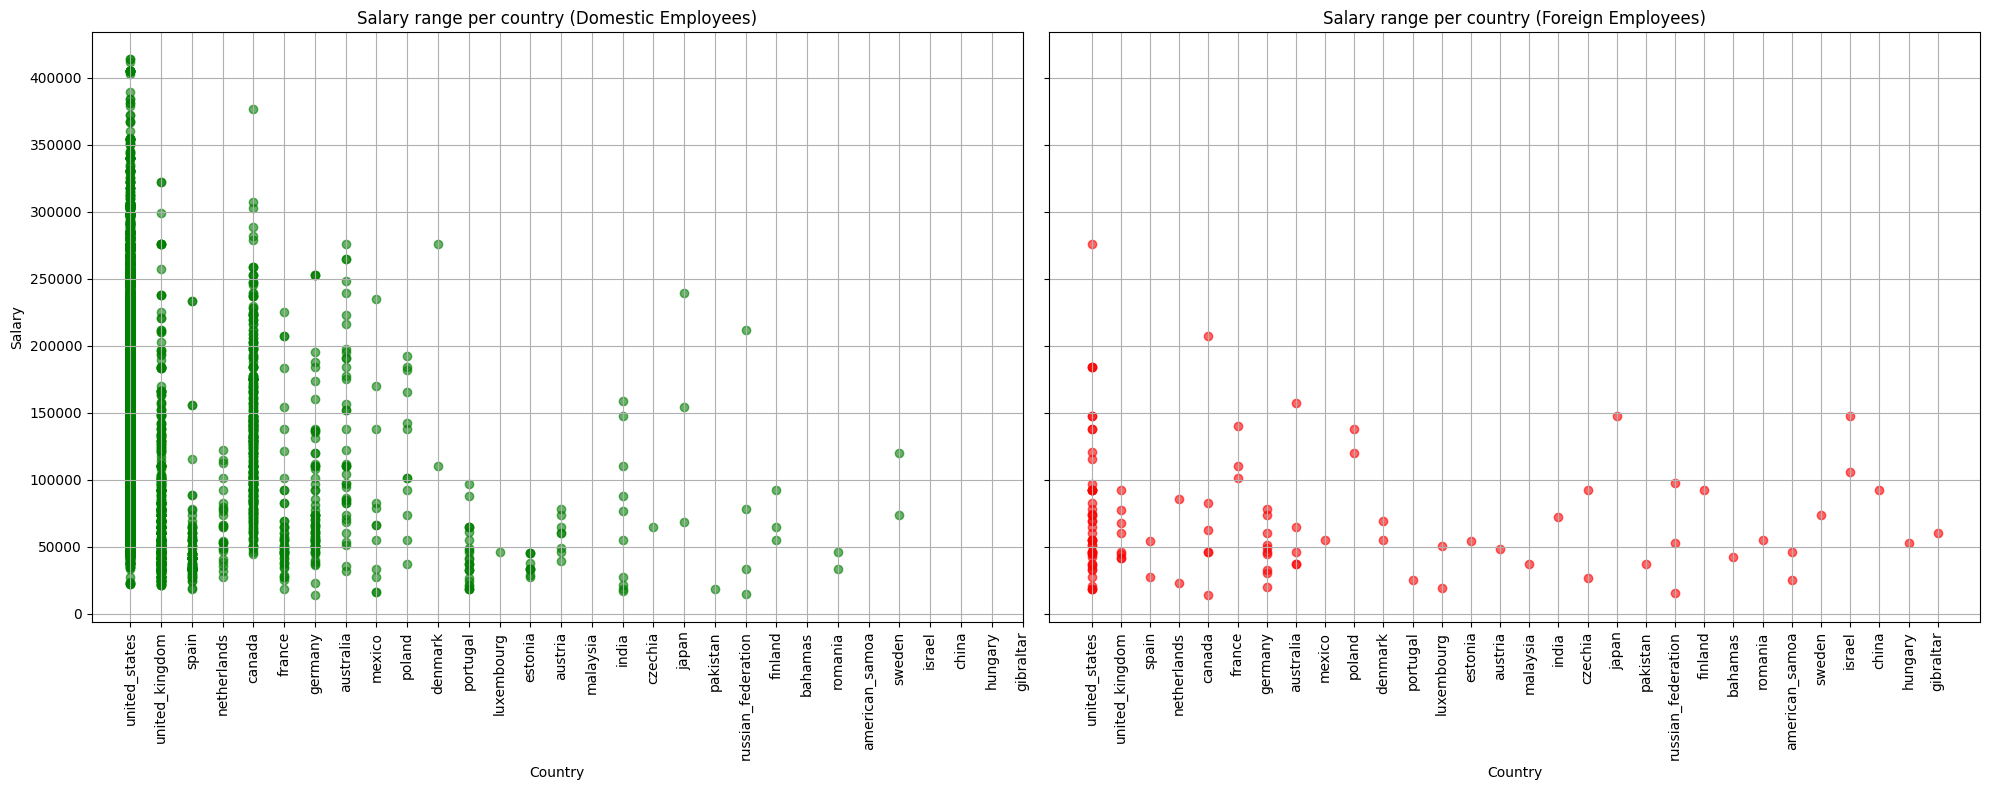

In [17]:
# Filter the data
countries_with_false = df_processed[df_processed['employee_of_country'] == False]['company_location'].unique()
df_filtered = df_processed[df_processed['company_location'].isin(countries_with_false)]

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot for green dots (employee_of_country == True)
for i, country in enumerate(df_filtered['company_location'].unique()):
    country_data = df_filtered[(df_filtered['company_location'] == country) & (df_filtered['employee_of_country'] == True)]
    ax1.scatter([i] * len(country_data), country_data['target'], color='green', alpha=0.6)

# Plot for red dots (employee_of_country == False)
for i, country in enumerate(df_filtered['company_location'].unique()):
    country_data = df_filtered[(df_filtered['company_location'] == country) & (df_filtered['employee_of_country'] == False)]
    ax2.scatter([i] * len(country_data), country_data['target'], color='red', alpha=0.6)

# Customize the plots
ax1.set_title('Salary range per country (Domestic Employees)')
ax1.set_xlabel('Country')
ax1.set_ylabel('Salary')
ax1.set_xticks(range(len(df_filtered['company_location'].unique())))
ax1.set_xticklabels(df_filtered['company_location'].unique(), rotation=90)
ax1.grid(True)

ax2.set_title('Salary range per country (Foreign Employees)')
ax2.set_xlabel('Country')
ax2.set_xticks(range(len(df_filtered['company_location'].unique())))
ax2.set_xticklabels(df_filtered['company_location'].unique(), rotation=90)
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

This scatterplot does suggest so, but it's easier to compare country side by side.
A violinplot would be nice, but it does funky things, boxplot does not show distribution as detailed as a boxenplot does, so we go for the latter. 

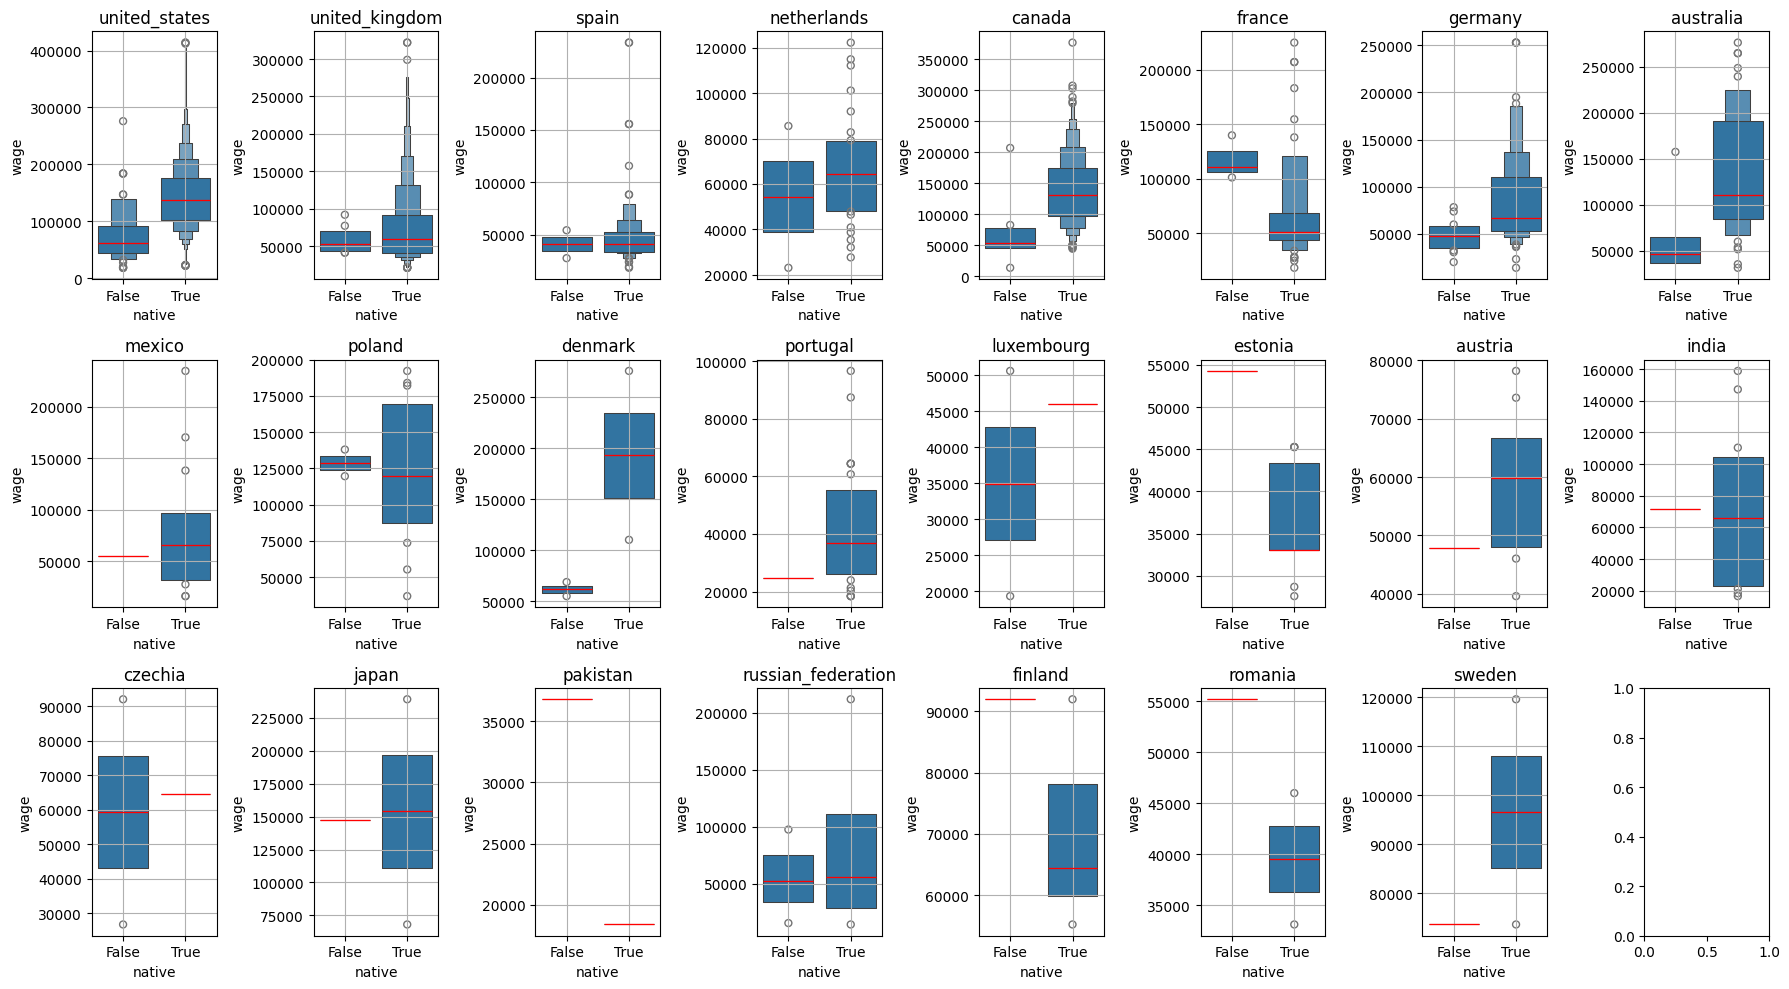

In [18]:
#Share Y-axis in boxplots: (1 or 0)
y_setting = 0       #zero = autoscale per subplot, 1 = shared y axis. 
plottype = 'boxen'  #box or boxen
##########

# Filter the data based on employee_of_country; the country should have both true and false to be interesting in this plot;
countries_with_false = df_processed[df_processed['employee_of_country'] == False]['company_location'].unique()
countries_with_true = df_processed[df_processed['employee_of_country'] == True]['company_location'].unique()
relevant_countries = list(set(countries_with_false) & set(countries_with_true))
df_filtered = df_processed[df_processed['company_location'].isin(relevant_countries)]

# Get the unique countries
unique_countries = df_filtered['company_location'].unique()
#print(len(unique_countries))

# Create the figure and subplots
y_axis_setting = 'all' if y_setting == 1 else None
fig, axes = plt.subplots(3, 8, figsize=(18, 10), sharey=y_setting)     #there are 30 countries that have foreign employees, 23 that have both this is what I'm interested in here, so 3by10
axes = axes.flatten()

# Plot for each country
for i, country in enumerate(unique_countries):
    ax = axes[i]
    country_data = df_filtered[df_filtered['company_location'] == country]
    # Create boxplot with values for country == country_data
    if plottype == 'boxen':
        sns.boxenplot(x='employee_of_country', y='target', data=country_data, ax=ax, legend=False, line_kws={'color': 'red'})
    else:
        sns.boxplot(x='employee_of_country', y='target', data=country_data, ax=ax, legend=False)
    ax.set_title(country)
    ax.set_xlabel('native')
    ax.set_ylabel('wage')

    ax.grid(True)

plt.tight_layout()
plt.show()

Some countries are more paritar than others. For example: Denmark has a very high unequality, whereas Spain has a very similar boxenplot (bar the outliers). This could be due to different job functions being filled out in different countries, at this stage of the EDA, we should put a pin in that idea and go to check the numerical distribution of jobs per country/function using barcharts and grids. If the grid shows us the ratios are similar between countries, then we can create more detailed boxenplots for Spain vs Denmark vs United States vs Japan... and a few others to see if certain job titles are not reachable for non-native employees. If the numbers are too low, then we have to conclude that there's not enough samples to make a statement about this. 

## 4.2. What's the distribution of jobs per country: (barchart)

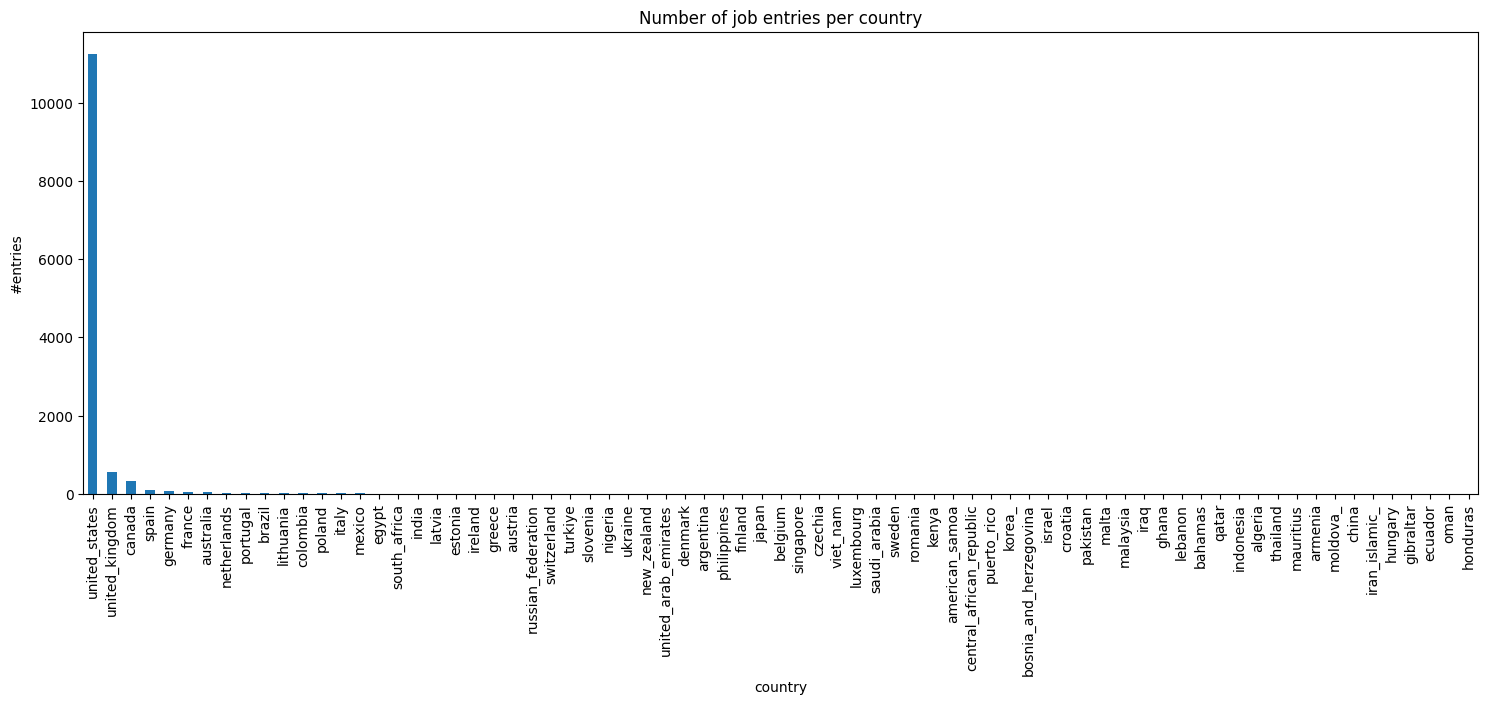

In [19]:
country_counts = df_processed['company_location'].value_counts()
plt.figure(figsize=(18, 6))
country_counts.plot(kind='bar')
plt.xlabel('country')
plt.ylabel('#entries')
plt.title('Number of job entries per country')
plt.show()

So the listings in the US are throwing off a lot, we need to keep this in mind as we continue making other visualizations. For the model it shouldn't matter too much. You could consider LOG visualizations, but they are not intuitive enough. In stead split it up: US vs the rest (one plot), the rest (detailled plot). This already circles back to the previous boxenplots made, we see that Denmark is not really representative - so investigating the titles is probably not worth it due to too little samples.

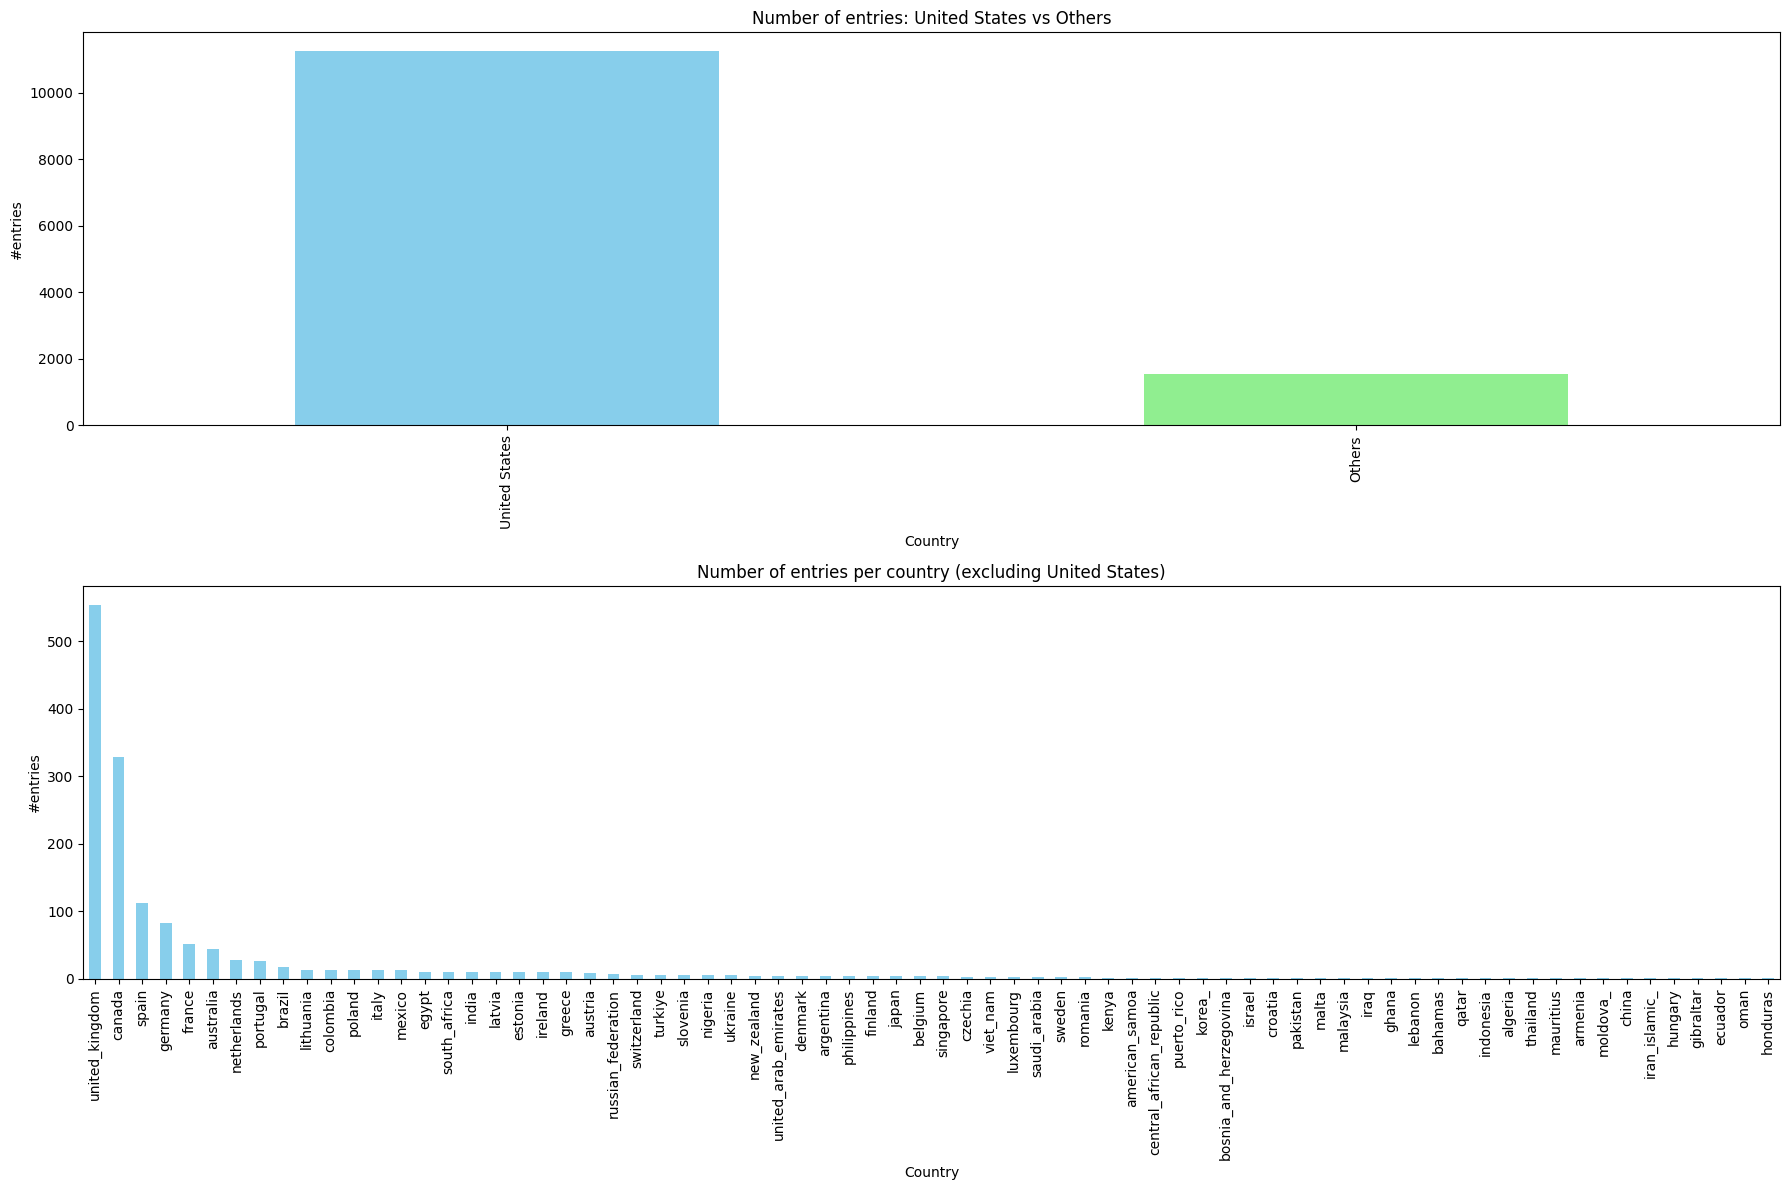

In [20]:
us_count = country_counts.get('united_states', 0)
other_counts = country_counts.drop('united_states').sum()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
first_plot_data = pd.Series({'United States': us_count, 'Others': other_counts})
first_plot_data.plot(kind='bar', color=['skyblue', 'lightgreen'], ax=ax1)
ax1.set_xlabel('Country')
ax1.set_ylabel('#entries')
ax1.set_title('Number of entries: United States vs Others')
other_country_counts = country_counts.drop('united_states')
other_country_counts.plot(kind='bar', color='skyblue', ax=ax2)
ax2.set_xlabel('Country')
ax2.set_ylabel('#entries')
ax2.set_title('Number of entries per country (excluding United States)')
plt.tight_layout()
plt.show()

even after combining all the data of non-us countries, we see that the dataset still heavily favours the United States. 

In [21]:
df_processed.loc[df_processed['company_location'] == 'honduras']

,work_year,experience_level,employment_type,job_title,employee_residence,work_setting,company_location,company_size,target,employee_of_country,field,title
12551,2020,Mid-level,Full-time,Product Data Analyst,honduras,In-person,honduras,S,18400.0,True,Product,Data Analyst


by the lookks of it, countries like Hondurs, Oman, only have one listing... that's problematic for a train test split... we might just throw a bunch of countries together if there's no big difference in their wages. repeat the above plot and add a second y-axis to show the median and average wage for each country. 

## 4.3. What's the amount of values we have per country/field and country/title?
For this visualization we'll make a kind of heatmap with x-y axis. Color intensity is the amount of rows at the xy-intersect.
- We're going to hide 0 values using a mask to not overload it visually with a bund of zeros; 
- Also

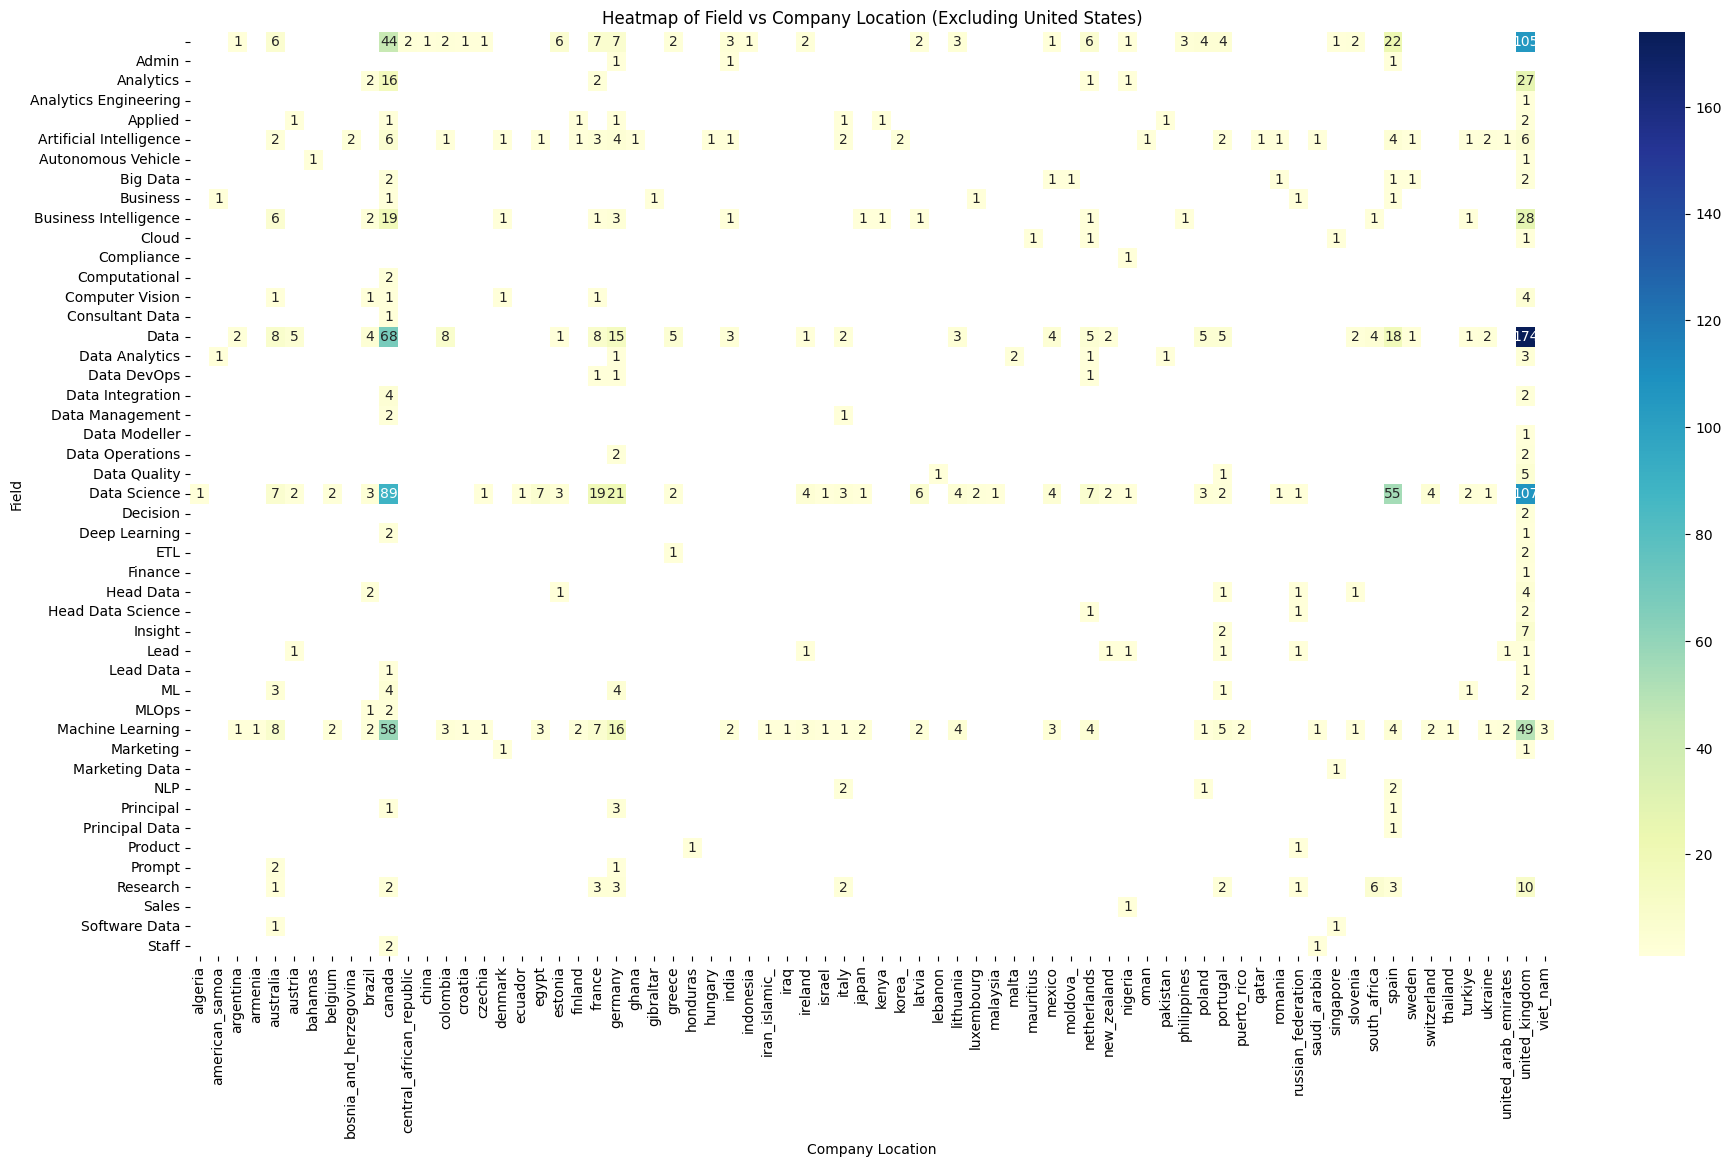

In [22]:
# Create a pivot table
pivot_table = df_processed.loc[df_processed['company_location'] != 'united_states'].pivot_table(index='field', columns='company_location', aggfunc='size', fill_value=0)
#hide zeros: 
mask = pivot_table == 0
# Create the heatmap
plt.figure(figsize=(22, 12))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", mask = mask)

# Set the labels
plt.xlabel('Company Location')
plt.ylabel('Field')
plt.title('Heatmap of Field vs Company Location (Excluding United States)')

# Show the plot
plt.show()

We look back at Denmark and see there are only four fields that have a listing: Marketing, Computer Vision, Business Intelligence, AI. All four of these fields hold only one listing - The pay discrepancy seen in the boxenplots might just be explained by the overall low number of listings in various fields. Because of this we will not further investigate wage inequality as the low number of listings makes it difficult to make meaningful statements. 

# 5 Grouping countries
We want to group countries into categories, there are a few ways to do this: 
1) Group based on geography (e.g. Europe, Asia, Africa, etc.): We have to ask ourselves "does this make sense for the wage?" i.e. is the wage tied to the geography of the country? If yes, then we can group by geography. If not, then we should look for another measure. We can use some common sense here: Mexico and Canada neighbour the US. However we see extremely divergent wages. (Boxenplot). So No, we're not going to group based on geography. 
2) GDP: We can group countries by GDP. This is a good measure because it is a good proxy for the wealth of a country (and the cost of living). We need to combine data from another source to make this work (World Bank or something). However, GDP or GDP per capita is a number - not a group so we still need to group them together based on some kind of clustering
3) World Bank Income Classification: this reduces the country dataset to easier to handle categories: Low, Lower-middle, Upper-middle, High-income countries. This is interesting for a few reasons: 
    - prevents feature inflation and long compute times. 
    - World Bank did studies on this and we can use their results. Better than winging it ourselves with the risk of making mistakes. (besides, with this dataset we only have income dat for IT jobs, this does not allow us direclty to make a statement for the overall income streams in a country)

To pull of the latter we need requests and need to download the data from the world bank: 

* WB Blogpost: https://blogs.worldbank.org/en/opendata/world-bank-country-classifications-by-income-level-for-2024-2025 
* downloadable dataset: https://databankfiles.worldbank.org/public/ddpext_download/site-content/OGHIST.xls 

We'll also need to do some kind of fuzzy matching (rapidfuzz, Levenshtein distance,....) When using this kind of fuzzy matching keep in mind to reduce some errors by preprocessing all countries in the same way!




## 5.1. Downloading and processing World Bank data

In [23]:
dataset_url = 'https://databankfiles.worldbank.org/public/ddpext_download/site-content/OGHIST.xls'
r = requests.get(dataset_url)
dest = "data/raw/OGHIST.xls"
with open(dest, "wb") as f:
    f.write(r.content)

In [24]:
income_df = pd.read_excel(dest, sheet_name='Country Analytical History', header= 5)   #year is in row 5
income_df = income_df.dropna(subset=['Unnamed: 0'])[['Unnamed: 0', 'Data for calendar year :', 2021]]
income_df = income_df.rename(columns={
    'Unnamed: 0': 'countrycode', 
    'Data for calendar year :': 'country',
    2021: 'rating'
    })

In [25]:
income_df = cleanup_strings(income_df, 'country', cleanup_countries)

In [26]:
income_df.sample()

,countrycode,country,rating
194,SYR,syrian_arab_republic,L


## 5.2 fuzzy matching: alligning both dataframes

In [27]:

def assign_country_codes(df_processed, income_df, processed_country_col, income_country_col, income_code_col, new_col_name):
    """
    Assigns the country codes from income_df to df_processed based on the highest fuzzy match score.
    
    Parameters:
        df_processed (pd.DataFrame): The dataframe to assign country codes.
        income_df (pd.DataFrame): The dataframe containing reference countries and their codes.
        processed_country_col (str): The column name in df_processed containing country names.
        income_country_col (str): The column name in income_df containing reference country names.
        income_code_col (str): The column name in income_df containing country codes.
    
    Returns:
        pd.DataFrame: The updated df_processed with an additional countrycode column.

    DISCLOSURE: Based on MWE made by ChatGPT, modified to fit needs.
    """
    # Create a mapping for country names to country codes
    country_to_code = dict(zip(income_df[income_country_col], income_df[income_code_col]))
    
    # Create a list of reference country names
    reference_countries = list(country_to_code.keys())
    
    # Initialize a column for country codes in df_processed
    df_processed[new_col_name] = None
    
    # Iterate through the rows in df_processed
    for index, row in df_processed.iterrows():
        # Get the country name from df_processed
        country_name = row[processed_country_col]
        
        # Find the best match for the country name in the reference list
        best_match, score, _ = process.extractOne(
            country_name, reference_countries, scorer=fuzz.token_sort_ratio
        )
        
        # Assign the corresponding country code if the match is confident enough
        if score > 80:  # Threshold for matching (adjust as needed)
            df_processed.at[index, new_col_name] = country_to_code[best_match]

    #patch for None values revealed by inspecting the unique_countries df: 
    #jersey is a british crown dependency, so we'll just assign it the code of the UK and be done with it.
    replacements = {
        'egypt': 'EGY', 
        'korea_': 'KOR', 
        'czechia': 'CZE', 
        'bahamas': 'BHS', 
        'hong_kong': 'HKG', 
        'jersey': 'GBR',
        'bolivia_plurinational_state_of': 'BOL'
        }
    for k,v in replacements.items():
        df_processed.loc[df_processed[processed_country_col] == k, new_col_name] = v

    
    return df_processed

In [28]:
df_processed = assign_country_codes(df_processed, income_df, 'company_location', 'country', 'countrycode', 'comp_location_WBI_code')
df_processed = assign_country_codes(df_processed, income_df, 'employee_residence', 'country', 'countrycode', 'employee_residence_WBI_code')

Fuzzy matching is done, I want to check if there are mistakes and manually correct these: 

Initially the code showed mistakes for egypt, korea_ (we're assuming south), czechia. All the rest is fine. The cause of the error is a high distance in the scoring algorithm. i'm not going to update the alghoritm - in stead just add these to the code as extra checks. Reason for this is that other countries are fine and an update to the algo might throw those off. The added code will use basic string matching and update the relevant rows. 

In [29]:
unique_rows = df_processed[['company_location', 'comp_location_WBI_code']].drop_duplicates()
unique_rows

,company_location,comp_location_WBI_code
0,united_states,USA
2,united_kingdom,GBR
8,spain,ESP
20,netherlands,NLD
31,canada,CAN
38,france,FRA
45,united_arab_emirates,ARE
51,egypt,EGY
72,south_africa,ZAF
195,germany,DEU


In [30]:
df_processed.sample(5)

,work_year,experience_level,employment_type,job_title,employee_residence,work_setting,company_location,company_size,target,employee_of_country,field,title,comp_location_WBI_code,employee_residence_WBI_code
5239,2023,Senior,Full-time,Data Engineer,united_states,In-person,united_states,M,165600.0,True,Data,Engineer,USA,USA
6429,2023,Senior,Full-time,Data Scientist,united_states,In-person,united_states,M,285448.4,True,Data Science,Data Scientist,USA,USA
9522,2023,Senior,Full-time,Data Scientist,united_states,Remote,united_states,M,143888.0,True,Data Science,Data Scientist,USA,USA
12209,2023,Senior,Full-time,Data Scientist,united_states,In-person,united_states,M,141312.0,True,Data Science,Data Scientist,USA,USA
12483,2023,Executive,Full-time,Data Engineer,united_states,In-person,united_states,M,115000.0,True,Data,Engineer,USA,USA


In [31]:
df_processed.loc[df_processed['comp_location_WBI_code'].isna()]  #GOOD!

,work_year,experience_level,employment_type,job_title,employee_residence,work_setting,company_location,company_size,target,employee_of_country,field,title,comp_location_WBI_code,employee_residence_WBI_code


In [32]:
df_processed.loc[df_processed['employee_residence_WBI_code'].isna()]  #GOOD!


,work_year,experience_level,employment_type,job_title,employee_residence,work_setting,company_location,company_size,target,employee_of_country,field,title,comp_location_WBI_code,employee_residence_WBI_code


## 5.4 Add income category of World Bank to df: 
fuzzy matching alligned both dataframes; now add the income code of the World Bank for both columns! The good thing is now that we found a way to ditch all the different countries and replace them by one column which makes sense to use an Ordinal Encoder on!! :)

In [33]:
rating_map = income_df.set_index('countrycode')['rating'].to_dict()
#for the country location: 
df_processed['location_income_category'] = df_processed['comp_location_WBI_code'].map(rating_map)
#for the employee residence:
df_processed['residence_income_category'] = df_processed['employee_residence_WBI_code'].map(rating_map)


In [34]:
df_processed.sample(6)

,work_year,experience_level,employment_type,job_title,employee_residence,work_setting,company_location,company_size,target,employee_of_country,field,title,comp_location_WBI_code,employee_residence_WBI_code,location_income_category,residence_income_category
8498,2023,Executive,Full-time,Data Engineer,united_states,In-person,united_states,M,101200.0,True,Data,Engineer,USA,USA,H,H
3149,2023,Senior,Full-time,Analytics Engineer,united_states,In-person,united_states,M,165434.4,True,Analytics,Engineer,USA,USA,H,H
2233,2022,Senior,Full-time,Data Engineer,united_states,In-person,united_states,L,211600.0,True,Data,Engineer,USA,USA,H,H
6721,2023,Senior,Full-time,Data Analyst,united_states,Remote,united_states,M,82800.0,True,,Data Analyst,USA,USA,H,H
695,2023,Senior,Full-time,Data Engineer,united_states,Remote,united_states,M,102120.0,True,Data,Engineer,USA,USA,H,H
2901,2023,Senior,Full-time,Business Intelligence Engineer,united_states,In-person,united_states,L,170200.0,True,Business Intelligence,Engineer,USA,USA,H,H


## 5.5 Prepare for ordinal encoding by making a map to order the income categories by the World Bank

In [ ]:
wbi_codes = {'L': 1, 'LM': 2, 'UM': 3, 'H': 4}  ##score them here! Use later for ordinal encoding

# 6: Further visualisations:
Listings per country where too sparse to really do something meaningful with - I opted to use studies by the World Bank to allow Ordinal encoding at a later stage. Right now I need to make a few more visualisation on the actual wages. Some questions I want to see answered: 
1) Did wage change over time (work_year + target)
2) How are wages evolving in each different country (we replaced countrycodes by income categories in step 5). 
3) Relation of wage and field. 
4) Pick a field with a lot of different listings and see if title makes a difference. 

## 6.1. Wage evolution over time: 

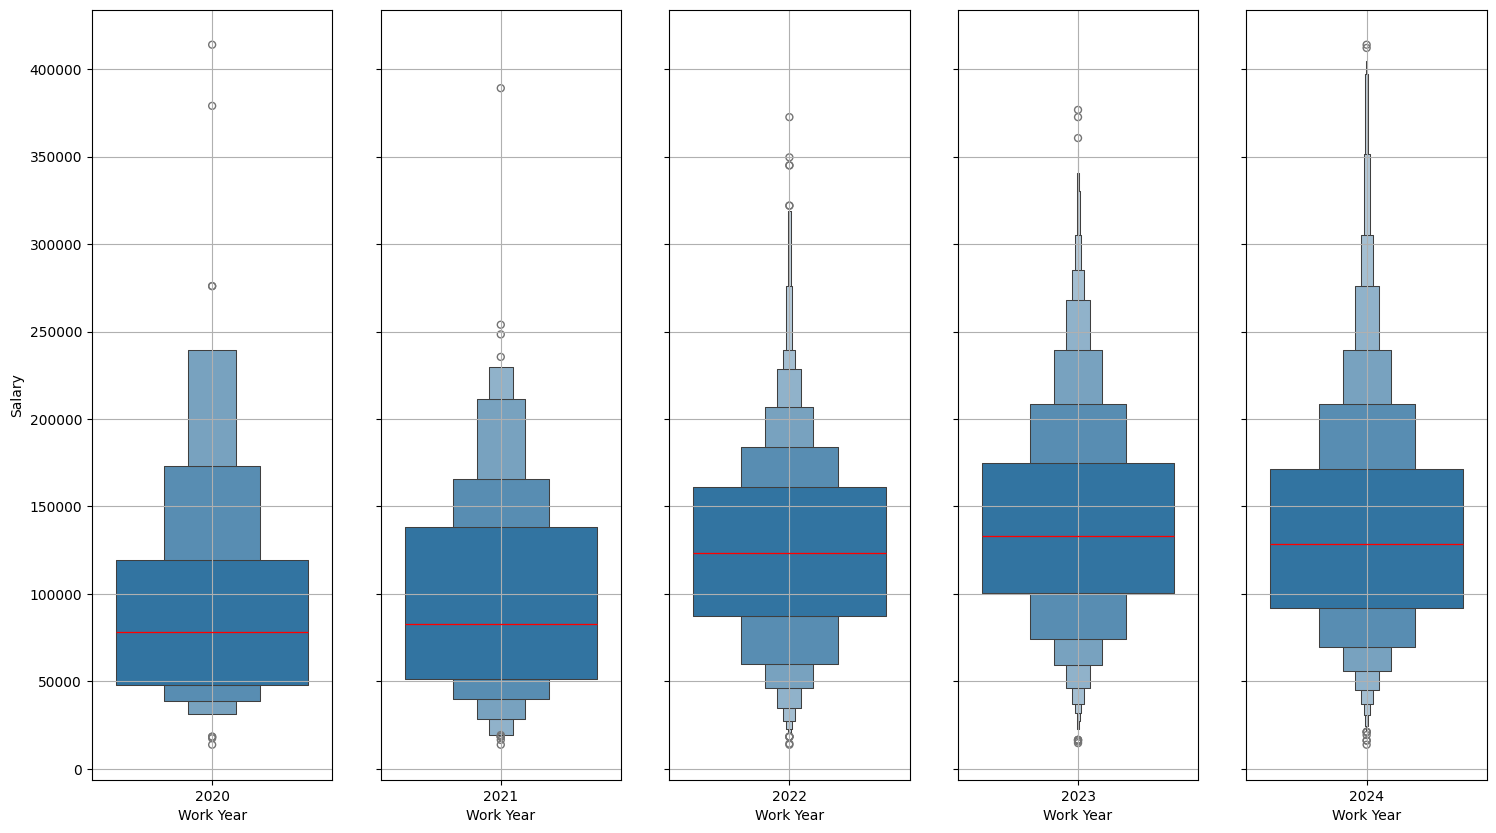

In [53]:
fig, axes = plt.subplots(1, 5, figsize=(18, 10), sharey=True)
years = sorted(df_processed['work_year'].unique())
for i, (year, ax) in enumerate(zip(years, axes)):
    sns.boxenplot(x='work_year', y='target', data=df_processed[df_processed['work_year'] == year], ax=ax, line_kws={'color': 'red'})
    ax.set_xlabel('Work Year')
    ax.set_ylabel('Salary')
    ax.grid(True)
plt.show()

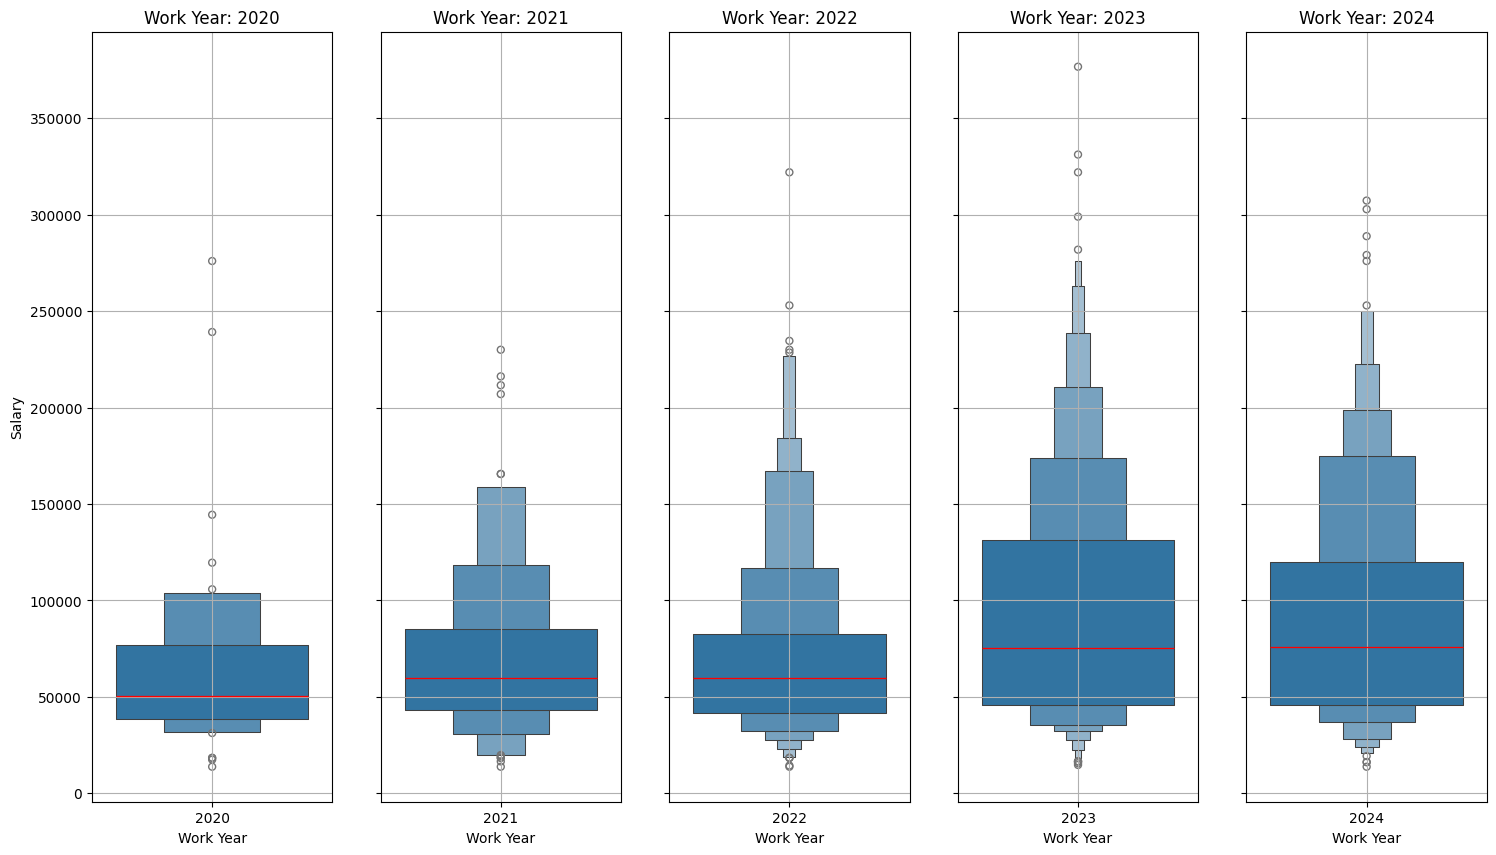

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(18, 10), sharey=True)
years = sorted(df_processed['work_year'].unique())
for i, (year, ax) in enumerate(zip(years, axes)):
    sns.boxenplot(x='work_year', y='target', data=df_processed[(df_processed['work_year'] == year) & (df_processed['comp_location_WBI_code'] != 'USA')], ax=ax, line_kws={'color': 'red'})
    ax.set_xlabel('Work Year')
    ax.set_ylabel('Salary')
    ax.grid(True)
plt.show()

6.1 Answer ==> YES in the overall dataset wage changed significantly over time. We can see the effect very clear for the full dataset (first boxenplot); when we ommit wages paid in the USA we see that the overal conclusion remains, but is less pronounced. Overall I'd say work year is a significant factor in determining the target.

The countrycode seems to be a factor too. Let's see how important it is with a linechart/timeseries setup. 

## 6.2. Country wage evolution

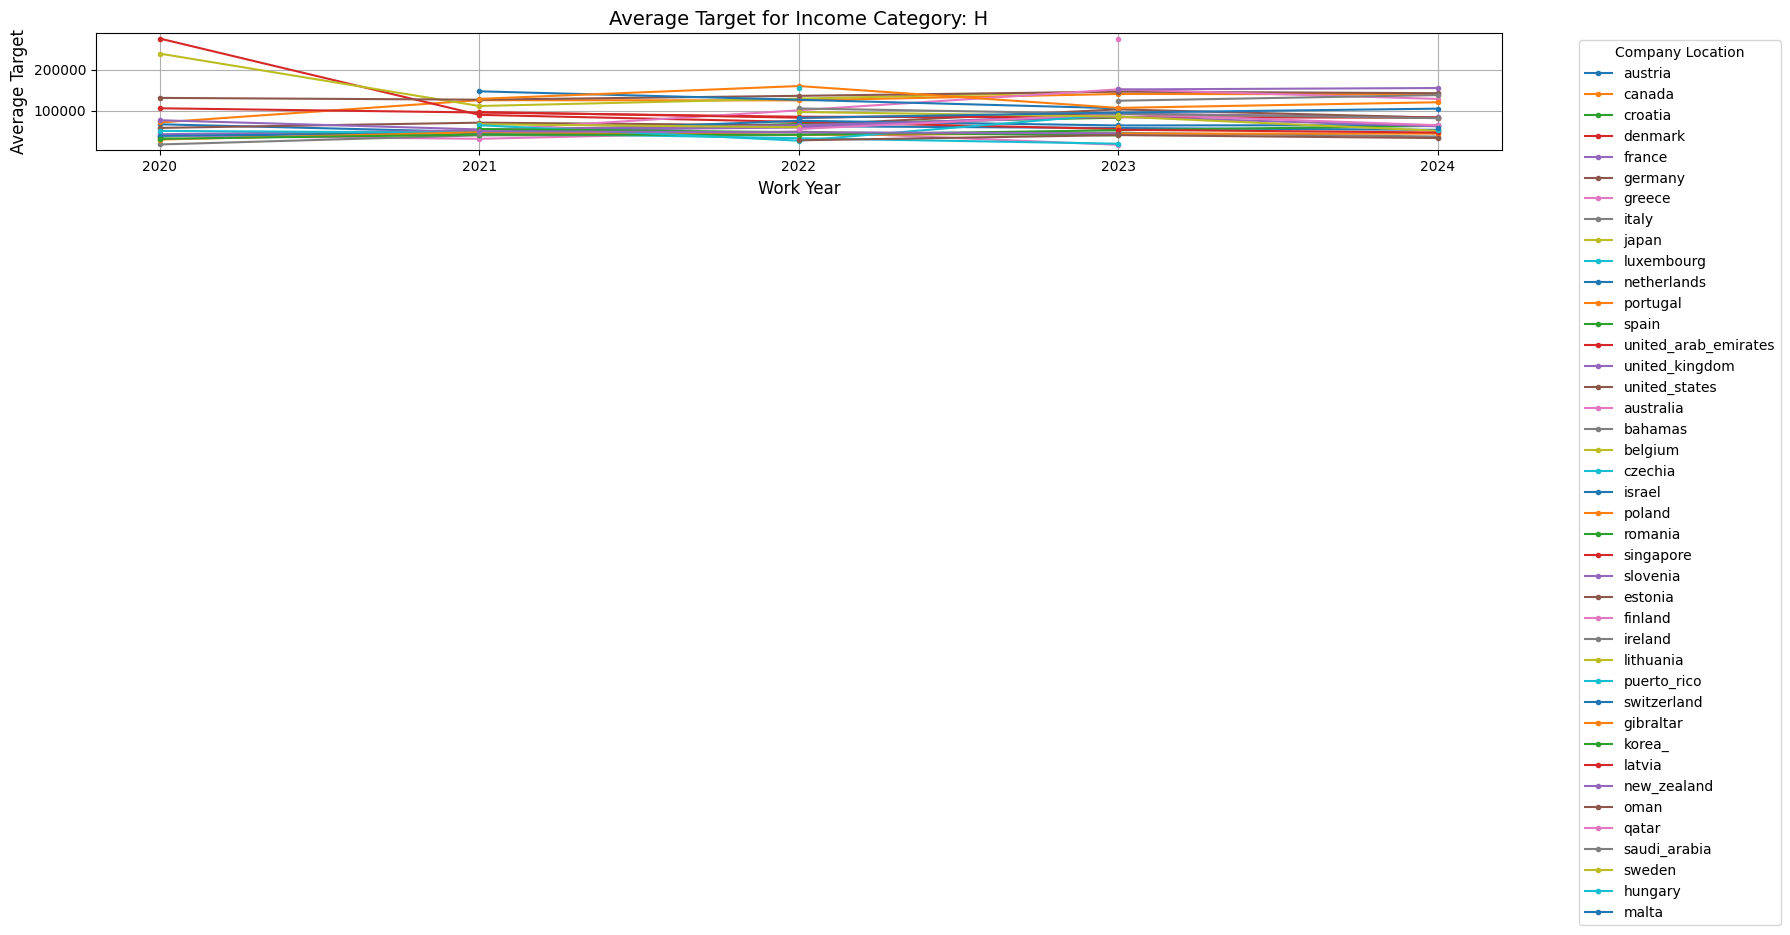

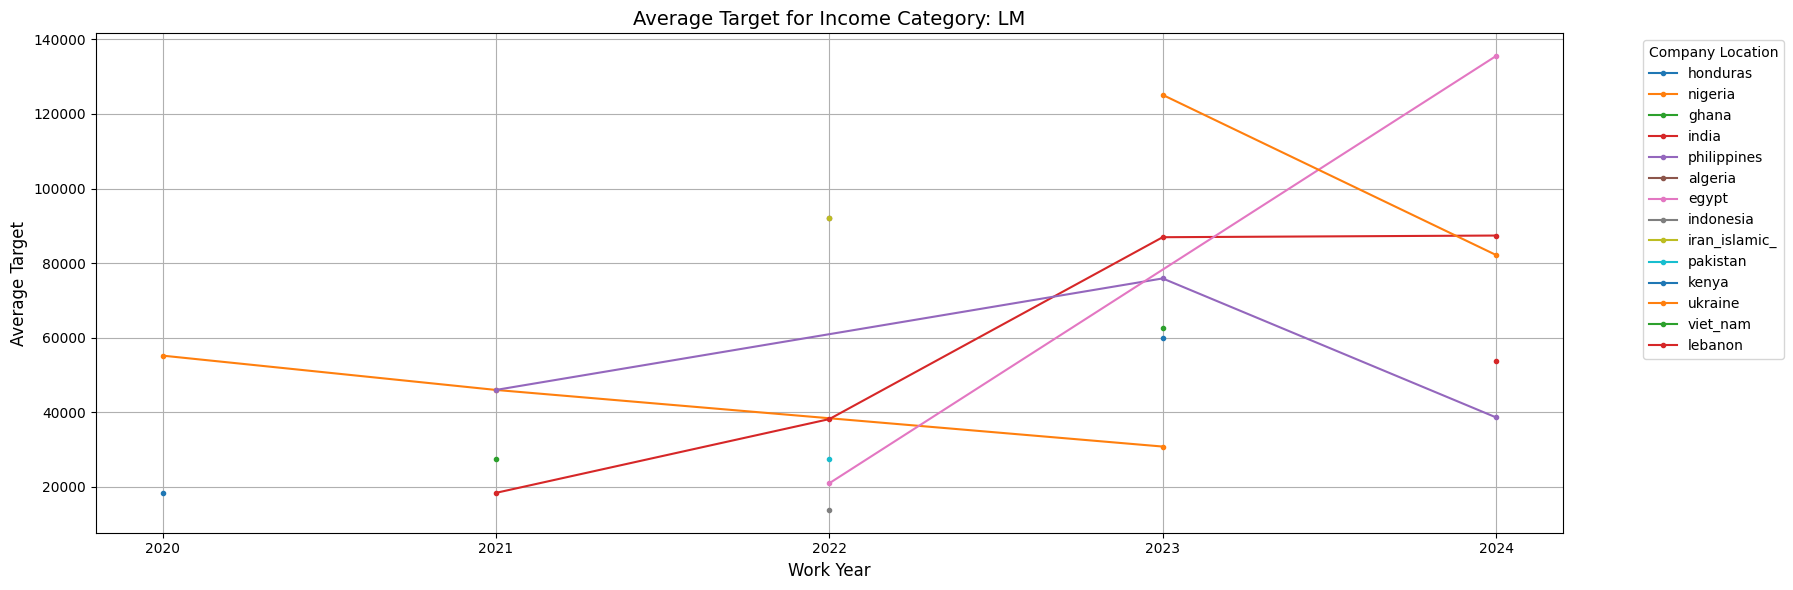

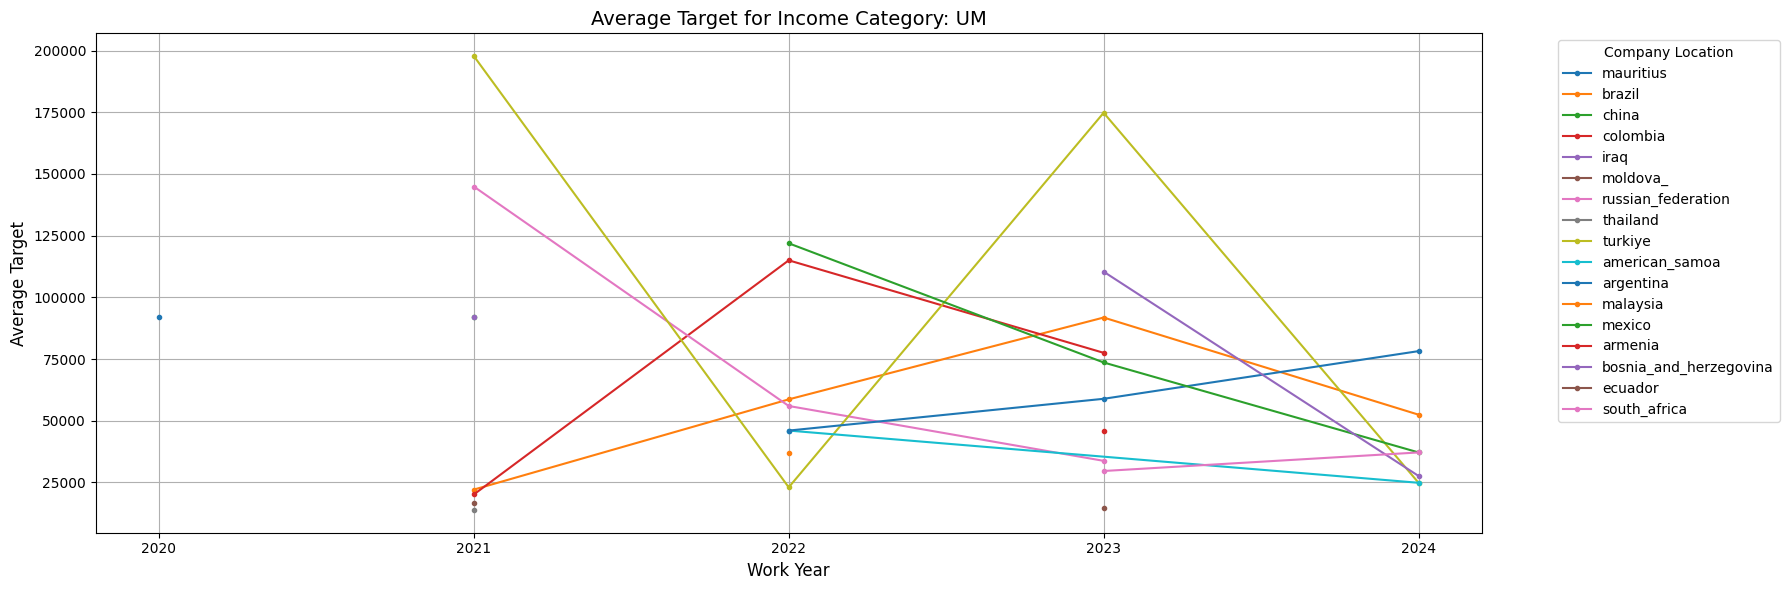

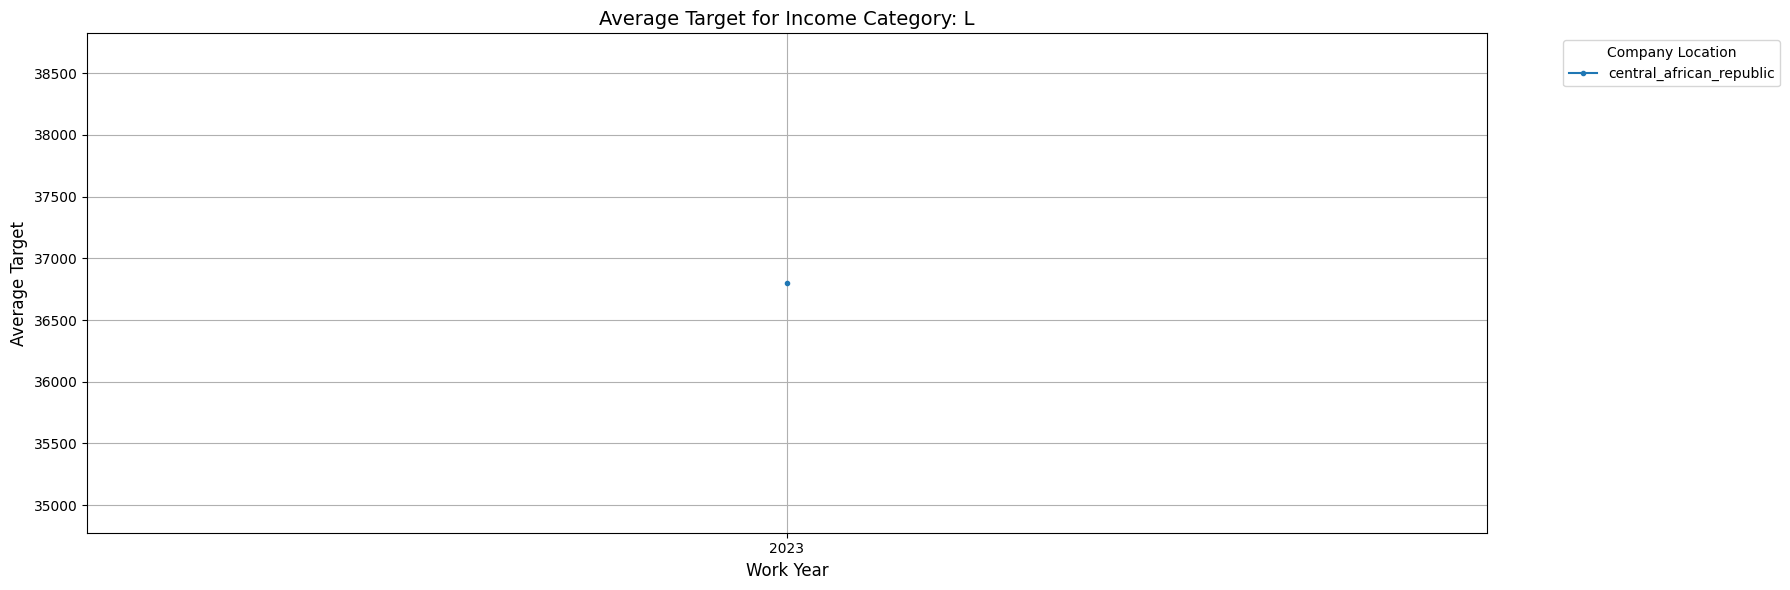

In [67]:
average_target = df_processed.groupby(['work_year', 'company_location', 'location_income_category'])['target'].mean().reset_index()

# Create separate plots for each 'location_income_category'
for category in df_processed['location_income_category'].unique():
    # Filter data for the current category
    category_data = average_target[average_target['location_income_category'] == category]
    
    # Initialize the plot
    plt.figure(figsize=(18, 6))
    
    # Iterate over each unique 'company_location'
    for location in category_data['company_location'].unique():
        location_data = category_data[category_data['company_location'] == location]
        plt.plot(
            location_data['work_year'],
            location_data['target'],
            marker='.',
            label=location
        )
        unique_years = category_data['work_year'].unique()
        plt.xticks(ticks=unique_years, labels=unique_years)
    # Customize the plot
    plt.title(f'Average Target for Income Category: {category}', fontsize=14)
    plt.xlabel('Work Year', fontsize=12)
    plt.ylabel('Average Target', fontsize=12)
    plt.legend(title='Company Location', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

some observations: 
1) the average wage for countries in the high-income category are less volatile than in any of the other categories. If we go back to the gridplot we can mostly explain this by there being more entries. 
2) High and Upper Middle countries seem to have quite some overlap - this could mean that we should keep the country added!!!! (we'll need to experiment with this)
3) A lot of countries are in the high income category - but even there we see a small upward trend. 

The best guess is to make two models and compare them using the RMSE (one with countries in OHE and one without the countries) - and see what performs best. 

## 6.3 Wages per field
In an earlier phase we split up the job title in two parts: the field and the title (e.g. Data Science Developer became: field = data_science and title = developer). This was also done with the idea to reduce the need for too many columns when performing OHE on this. For now I quickly want to see how the wage distribution is per field per income category by country. We'll use a scatterplot. We've established that the year is important across the whole dataset, so we'll focus on a single year. Horizontal boxplots would work nicely for this. 

In [93]:
year = df_processed.work_year.value_counts().idxmax()
#most for 2023, let's use that as our focus year. 

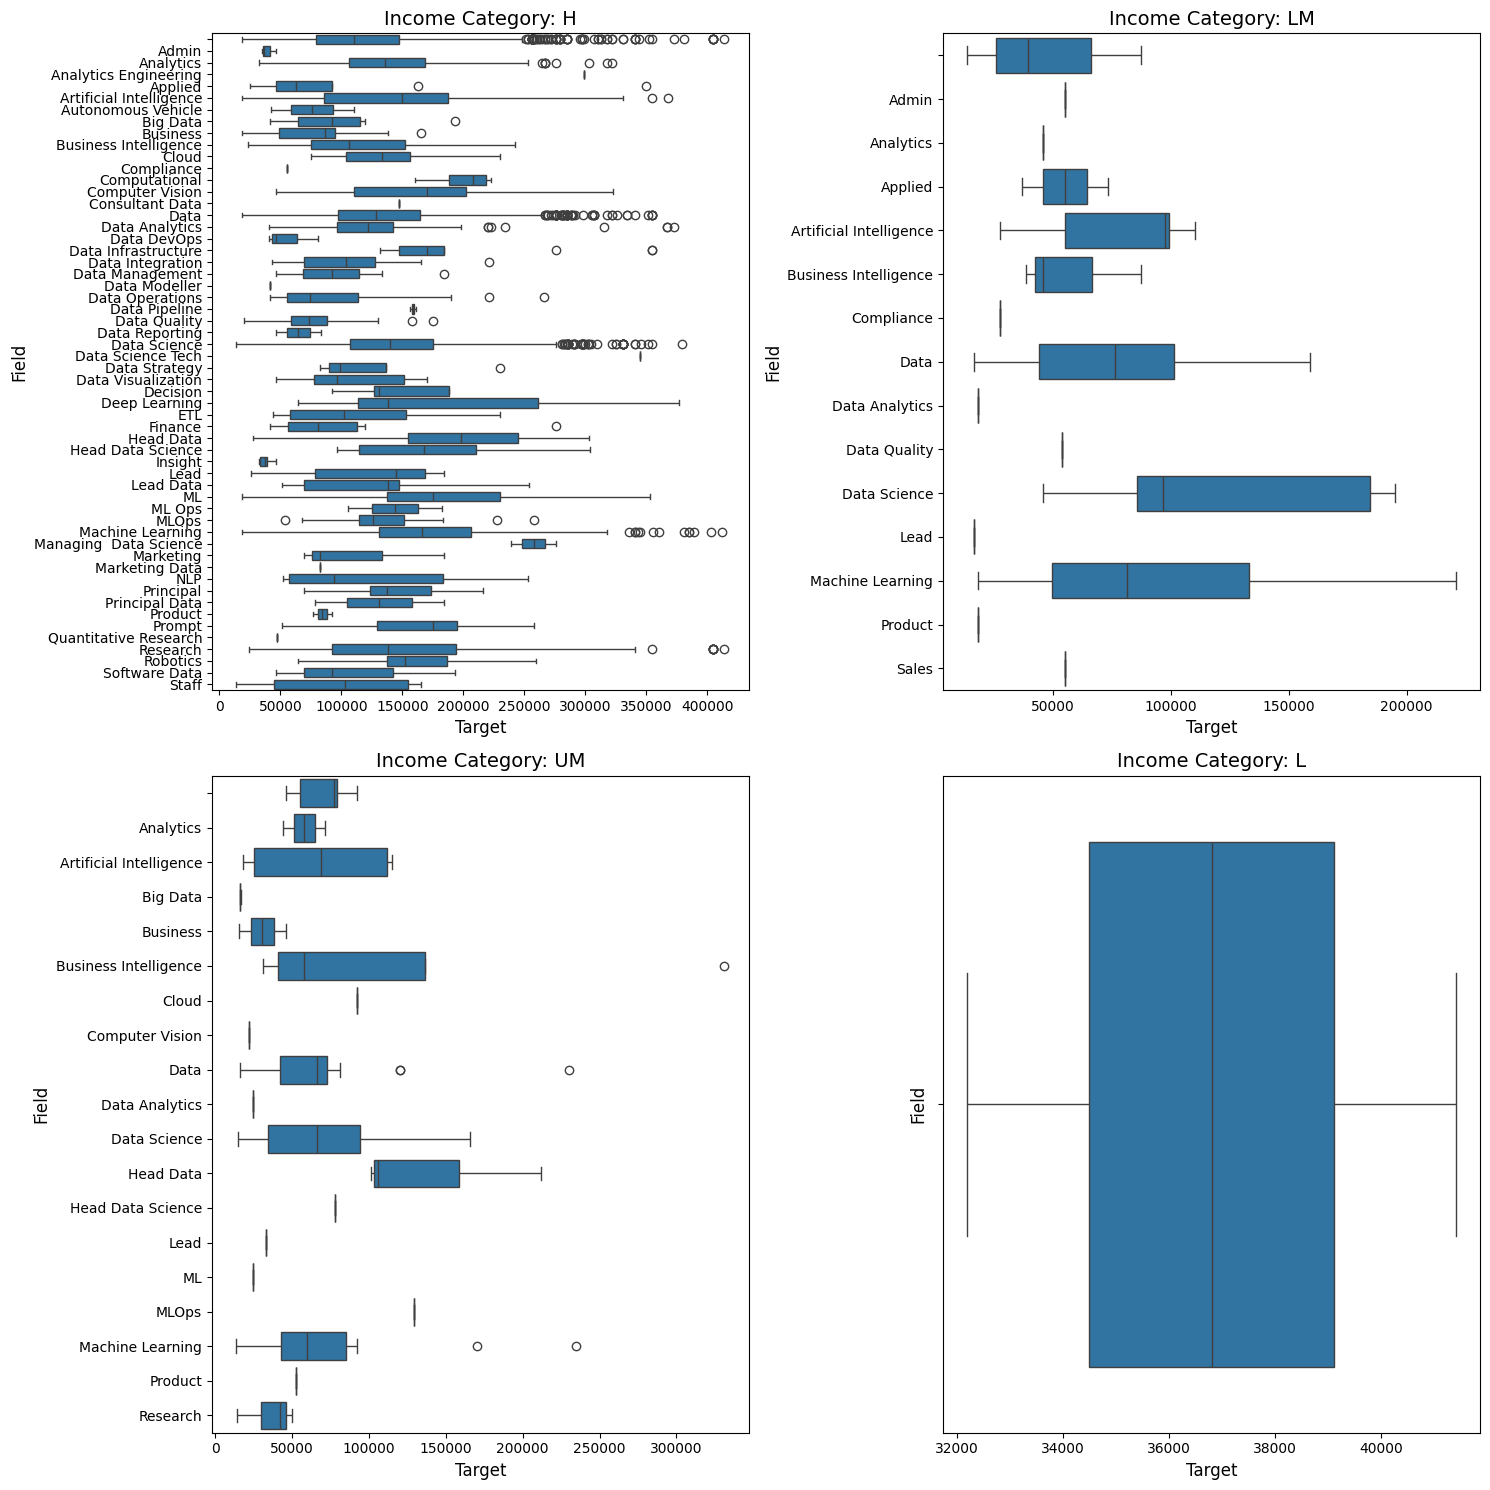

In [ ]:
# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Flatten axes for easier iteration
axes = axes.flatten()

# List of unique 'location_income_category' values
categories = df_processed['location_income_category'].unique()

# Iterate over each 'location_income_category' and corresponding subplot axis
for ax, category in zip(axes, categories):
    # Filter data for the current category and sort by 'field'
    category_data = df_processed[df_processed['location_income_category'] == category].sort_values(by='field')
    
    # Create horizontal boxplot
    sns.boxplot(
        y='field',  # Replace 'field' with the actual column name
        x='target',
        data=category_data,
        ax=ax,
        orient='h'  # Horizontal orientation
    )
    
    # Customize the plot
    ax.set_title(f'Income Category: {category}', fontsize=14)
    ax.set_xlabel('Target', fontsize=12)
    ax.set_ylabel('Field', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

For similar fields the split in H, UM, LM and L income categories seems to make sense - so the data provided from the WBI file is actually more usefull than the previous lineplots showed. 

## 6.4 Wages per level in a given field

In [98]:
topfield = df_processed.query("work_year == @year").field.value_counts().idxmax()
topfield

'Data'

In [ ]:
# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Flatten axes for easier iteration
axes = axes.flatten()

# List of unique 'location_income_category' values
categories = df_processed['location_income_category'].unique()

# Iterate over each 'location_income_category' and corresponding subplot axis
for ax, category in zip(axes, categories):
    # Filter data for the current category and sort by 'field'
    category_data = df_processed[(df_processed['location_income_category'] == category)& (df_processed['field'] == topfield)].sort_values(by='title')
    
    # Create horizontal boxplot
    sns.boxplot(
        y='field',  # Replace 'field' with the actual column name
        x='target',
        data=category_data,
        ax=ax,
        orient='h'  # Horizontal orientation
    )
    
    # Customize the plot
    ax.set_title(f'Income Category: {category}', fontsize=14)
    ax.set_xlabel('Target', fontsize=12)
    ax.set_ylabel('Field', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()